# Mapping loneliness area scores from GP points, NI 2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from shapely.geometry import Point
import rasterio as rst
from rasterstats import zonal_stats

## Join GPs to postcodes

- Get coordinates for postcodes in the UK
- https://geoportal.statistics.gov.uk/datasets/9ac0331178b0435e839f62f41cc61c16

*File needs to be manually downloaded and saved in mapping_data/ folder*

In [3]:
nspl = pd.read_csv("C:/Users/JennaTan/Downloads/NSPL_MAY_2022_UK.csv", low_memory = False)

In [4]:
nspl.head(2)

,pcd,pcd2,pcds,dointr,doterm,usertype,oseast1m,osnrth1m,osgrdind,oa11,...,ru11ind,oac11,lat,long,lep1,lep2,pfa,imd,calncv,stp
0,AB1 0AA,AB1 0AA,AB1 0AA,198001,199606.0,0,385386.0,801193.0,1,S00090303,...,3,1C3,57.101474,-2.242851,S99999999,S99999999,S23000009,6715,S99999999,S99999999
1,AB1 0AB,AB1 0AB,AB1 0AB,198001,199606.0,0,385177.0,801314.0,1,S00090303,...,3,1C3,57.102554,-2.246308,S99999999,S99999999,S23000009,6715,S99999999,S99999999


In [5]:
nspl = nspl[["pcds", "oseast1m", "osnrth1m", "lsoa11", "msoa11" ]]
nspl["pcds"] = nspl.pcds.str.replace(" ", "")

In [16]:
# Read loneliness scores by GP df
df = pd.read_csv("../../extdata/ni_gp_2022.csv")

In [17]:
print(len(df))
df.head(2)

231


,postcode,loneliness_zscore
0,BT100BX,0.800423
1,BT119EA,-1.410811


In [18]:
df.rename(columns = {"postcode":"pcds"}, inplace = True)

In [19]:
df = df.merge(nspl, on = "pcds", how = "left")

In [20]:
df.isna().value_counts()

pcds   loneliness_zscore  oseast1m  osnrth1m  lsoa11  msoa11
False  False              False     False     False   False     231
Name: count, dtype: int64

In [21]:
df.head(2)

,pcds,loneliness_zscore,oseast1m,osnrth1m,lsoa11,msoa11
0,BT100BX,0.800423,330432.0,369844.0,95GG23S3,N99999999
1,BT119EA,-1.410811,329737.0,371336.0,95GG01S2,N99999999


## Read DF as Geopanda

In [22]:
# CRS =  EPSG 27700, reads gpd as British National Grid coords
# Create a new col 'geometry'

geo_data = gpd.GeoDataFrame(data = df, 
                            crs = {'init':'epsg:27700'}, 
                            geometry = df.apply(lambda geom: Point(geom['oseast1m'],geom['osnrth1m']),axis=1))
geo_data.head()

C:\Users\JennaTan\Documents\loneliness\venv_loneliness\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,pcds,loneliness_zscore,oseast1m,osnrth1m,lsoa11,msoa11,geometry
0,BT100BX,0.800423,330432.0,369844.0,95GG23S3,N99999999,POINT (330432.000 369844.000)
1,BT119EA,-1.410811,329737.0,371336.0,95GG01S2,N99999999,POINT (329737.000 371336.000)
2,BT119FZ,-2.735769,329097.0,371029.0,95GG01S1,N99999999,POINT (329097.000 371029.000)
3,BT124HL,-7.883440,332828.0,374124.0,95GG21S2,N99999999,POINT (332828.000 374124.000)
4,BT124LP,0.207509,332449.0,373831.0,95GG21S1,N99999999,POINT (332449.000 373831.000)


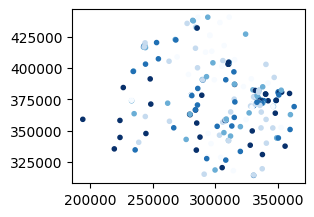

In [26]:
# Visualise loneliness score geographically using geometry col
geo_data.plot(column = 'loneliness_zscore', scheme = 'quantiles', cmap = 'Blues', marker = '.', figsize=(3,3));

- Reflects shape of NI
- Somewhat evenly distributed, with cluster around Belfast
- Darker dots around Belfast and SE - higher levels of loneliness - expect to see replication

## Develop KNN; predict unknown points

### Instantiate KNN as IDW model

In [27]:
def idw_model(k, p):
    """
    Instantiates a KNN regressor as an IDW interpolater. k = no. neighbours, p = power for idw
    """
    def _inv_distance_index(weights, index=p):
        """Weights set as distance from the input points and neighbour, with an inverse calculation of (1/dist**power).
        Values not dividable by 0 are ignored.
        """
        #return (test==0).astype(int) if np.any(weights == 0) else 1. / weights**index
        
        with np.errstate(divide='ignore', invalid='ignore'):
            safe_weights = 1. / weights**index
        return np.nan_to_num(safe_weights, posinf=0) # ignore weights that are negative
        
    return KNeighborsRegressor(k, weights=_inv_distance_index)

### Train test split

In [28]:
# Get existing point locations and values to fit the model
points = geo_data[['oseast1m','osnrth1m']].values
vals = geo_data['loneliness_zscore'].values

In [29]:
len(vals)

231

In [30]:
X_train, X_test, y_train, y_test = train_test_split(points, vals, test_size=0.2, random_state=42)

### Find best k and p

In [136]:
param_grid = {
    'n_neighbors': [2, 3, 5, 6, 6 ],
    'p': [ 1, 1.5, 2]
}

knn_model = idw_model(1,1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(knn_model, param_grid, cv=kf)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(n_neighbors=1,
                                           weights=<function idw_model.<locals>._inv_distance_index at 0x000001C805E24550>),
             param_grid={'n_neighbors': [2, 3, 5, 6, 6], 'p': [1, 1.5, 2]})

In [137]:
best_k = grid_search.best_params_['n_neighbors']
best_p = grid_search.best_params_['p']

print("Best k:", best_k)
print("Best p:", best_p)

Best k: 6
Best p: 1


In [139]:
grid = idw_model(6,1).fit(X_train, y_train)
original = idw_model(5,2).fit(X_train, y_train)

y_pred_grid = grid.predict(X_test)
y_pred_original = original.predict(X_test)

In [140]:
print(f" Grid Search MSE: {mean_squared_error(y_test, y_pred_grid)}")
print(f" Original params MSE: {mean_squared_error(y_test, y_pred_original)}")

 Grid Search MSE: 6.861520677492416
 Original params MSE: 8.602814620068047


Note that the dataset is small - don't want too many neighbours

### Use best params to fit model

In [141]:
idw = idw_model(6, 1).fit(points, vals)

### Create grid of values to predict

In [142]:
# Get minimum and maximum coords from the data
print("xmin = ", geo_data['oseast1m'].min(), "\n\r",
      "xmax = ", geo_data['oseast1m'].max(), "\n\r",
      "ymin = ", geo_data['osnrth1m'].min(), "\n\r",
      "ymax = ", geo_data['osnrth1m'].max())

xmin =  194098.0 
 xmax =  362801.0 
 ymin =  314327.0 
 ymax =  440595.0


In [143]:
xmin =  194098.0 
xmax =  362801.0 
ymin =  314327.0 
ymax =  440595.0

In [144]:
def grid(xmin, xmax, ymin, ymax, cellsize):
    """
    Creates an evenly spaced grid structure of all possible x and y coords within the bounds of the data that will be 
    used for prediction. Even spacing ensures reliable and uniform coverage of the surface for estimation.
    
    """
    # Adjust x and y ranges to be perfectly divisible by cellsize using floor and ceiling division, ensuring even spacing
    xmin = (xmin // cellsize) * cellsize 
    xmax = -(-xmax // cellsize) * cellsize 
    ymin = (ymin // cellsize) * cellsize
    ymax = -(-ymax // cellsize) * cellsize
    
    # Generate coords within adjusted min/max range with regular spacing determined by cellsize
    x = np.linspace(xmin,xmax,int((xmax-xmin)/cellsize))
    y = np.linspace(ymin,ymax,int((ymax-ymin)/cellsize))
    
    # Create grid structure of all possible x and y points, returns two 2D arrays
    xx,yy = np.meshgrid(x,y)
   
    return xx, yy

In [145]:
# cellsize = 250 represents BNG 250m x 250m square
xx,yy = grid(xmin, xmax, ymin, ymax, 200 )

In [146]:
def reshape_grid(xx,yy):
    """ 
    Reshape output of the meshgrid into a single array combining x and y coords.
    Ravel flattens xx/yy into (1,n) and [] turns it into a col vector (n,1). 
    Two col vectors combined to form xy
    """
    return np.append(xx.ravel()[:,np.newaxis],yy.ravel()[:,np.newaxis],1)

In [147]:
xy = reshape_grid(xx,yy)

### Predict unknown values using trained KNN model

In [148]:
# Predict values in the grid. Returns 1D array, (n,1)
scores = idw.predict(xy)

In [149]:
scores.shape

(534040,)

### Reshape predictions to grid

- KNN Regresor outputs a 1D array - predictions per coordinate
- It needs to be reshaped to 2D to allign with the xx,yy meshgrid

In [150]:
def reshape_image(scores, xx):
    return np.flip(scores.reshape(np.shape(xx)),0)

scores = reshape_image(scores, xx)

In [151]:
scores.shape == xx.shape

True

### Inspect surface outcome

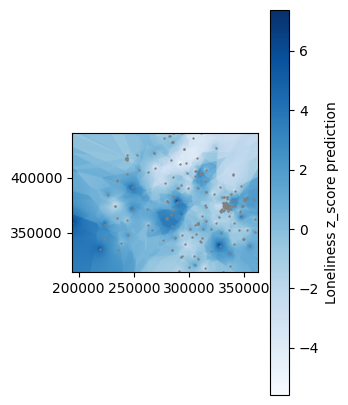

In [152]:
f, ax = plt.subplots(figsize = (3,5))
#ax.imshow(z, cmap='Reds')
#ax.set_aspect('equal')

heatmap = ax.imshow(scores, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax.scatter(points[:, 0], points[:, 1], color='grey', s=0.5)
cbar = plt.colorbar(heatmap, ax=ax, label='Loneliness z_score prediction')


Lighter areas around the cities

## Map to Super Data Zones - 850 in NI

- Get shape files : https://www.nisra.gov.uk/publications/geography-super-data-zone-boundaries-gis-format
- Get zonal stats 

In [153]:
# Get Super Data Zones which we use to aggregate the z score variable.
filestring = r'C:/Users/JennaTan/Downloads/geography-sdz2021-esri-shapefile/SDZ2021.shp'

sdz = gpd.read_file(filestring)
sdz.to_crs({'init':'epsg:27700'}).head(5) # projects coordinates onto British National Grid

C:\Users\JennaTan\Documents\loneliness\venv_loneliness\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,SDZ2021_cd,SDZ2021_nm,DEA2014_cd,DEA2014_nm,LGD2014_cd,LGD2014_nm,Area_ha,Perim_km,geometry
0,N21000001,Dunsilly_A,N10000104,Dunsilly,N09000001,Antrim and Newtownabbey,6611.41,57.65,"POLYGON ((117031.303 551876.113, 117034.808 55..."
1,N21000002,Dunsilly_B,N10000104,Dunsilly,N09000001,Antrim and Newtownabbey,7296.19,51.27,"POLYGON ((134309.284 553534.212, 134307.618 55..."
2,N21000003,Dunsilly_C,N10000104,Dunsilly,N09000001,Antrim and Newtownabbey,2794.37,28.18,"POLYGON ((117027.220 551873.797, 117031.284 55..."
3,N21000004,Dunsilly_D,N10000104,Dunsilly,N09000001,Antrim and Newtownabbey,111.61,7.45,"POLYGON ((121508.686 547161.486, 121421.232 54..."
4,N21000005,Dunsilly_E,N10000104,Dunsilly,N09000001,Antrim and Newtownabbey,80.94,5.43,"POLYGON ((122838.655 548253.411, 122850.384 54..."


In [154]:
sdz.SDZ2021_cd.nunique()

850

In [155]:
# Affine transformation maps pixels from the KNN estimates to spatial coordinates of each IZ's geometry in BNG space
# 250 = pixels resolution (size of each pixel in x/y direction) = 250mx250m
# 125 = spatial alignment in x/y direction = centres 

trans = rst.Affine.from_gdal(xmin-100,200,0,ymax+100,0,-200)

In [156]:
# Get the mean predicted score based on MSOA polygon shape, returns a dictionary
sdz_zone = zonal_stats(sdz['geometry'], scores, affine = trans, stats = 'mean', nodata = np.nan)

In [157]:
len(sdz_zone)

850

In [158]:
sdz_zone[846]

{'mean': None}

In [159]:
# Extract score from dictionary, turn into a list and add as col in .shp
sdz['loneliness_zscore'] = list(map(lambda x: x['mean'] , sdz_zone))

<Axes: >

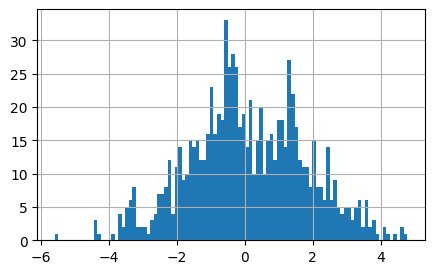

In [133]:
sdz['loneliness_zscore'].hist(bins = 100, figsize = (5,3))

In [134]:
sdz['loneliness_zscore'].isna().value_counts()

loneliness_zscore
False    847
True       3
Name: count, dtype: int64

In [135]:
sdz.loc[846]

SDZ2021_cd                                                   N21000847
SDZ2021_nm                                            Ards_Peninsula_J
DEA2014_cd                                                   N10001101
DEA2014_nm                                              Ards Peninsula
LGD2014_cd                                                   N09000011
LGD2014_nm                                         Ards and North Down
Area_ha                                                         118.41
Perim_km                                                          7.82
geometry             POLYGON ((365372.3300000001 358780.34699999914...
loneliness_zscore                                                  NaN
Name: 846, dtype: object

In [95]:
sdz["rank"] = sdz["loneliness_zscore"].rank()
sdz["deciles"] = pd.qcut(sdz["loneliness_zscore"], q=10, labels=False)

C:\Users\JennaTan\AppData\Local\Temp\ipykernel_15968\1612988582.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu', len(decile_values))


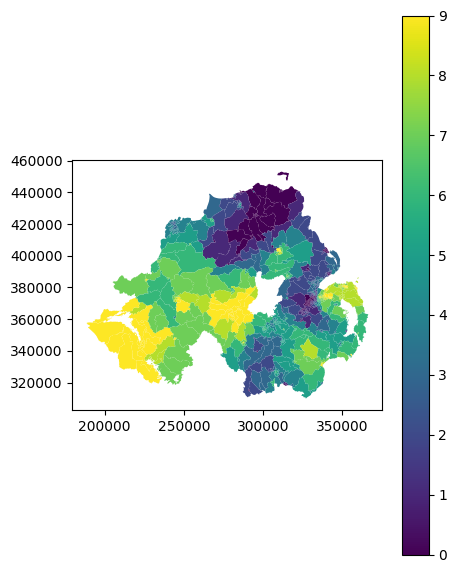

In [96]:
from matplotlib.patches import Patch
import matplotlib.cm as cm

decile_values = sdz['deciles'].unique()

# Automatically generate colors based on the number of unique decile values
cmap = cm.get_cmap('RdYlBu', len(decile_values))

# Create the legend handles for each decile range
handles = []
for i, decile in enumerate(decile_values):
    col = cmap(i)
    handles.append(Patch(facecolor=col, label=f"Decile {decile}"))

# Create the plot of Scotland map with the decile colors
fig, ax = plt.subplots(figsize=(5, 7))
sdz.plot(column='deciles', ax=ax, legend=True);
